Signal decomposition with Deep Learning  
Author: Javier Gamero Muñoz

# General libraries

In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from decompose import quality

# Load data

In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
PATH

'/Users/javigamero/MyMac/DS_Master/TFM'

In [3]:
idx_path = os.path.join(PATH, 'data_preproc/LightSignal_total.csv')
idxs = pd.read_csv(idx_path, sep=';', header=None)
idxs = np.array(idxs.iloc[:,0]).reshape(-1)
idxs

array(['0_1', '0_4', '0_6', ..., '399_42', '399_43', '399_48'],
      dtype=object)

In [4]:
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')
t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t.set_index(0, inplace=True)

In [5]:
t0 = 150 # (ns), moment to start considering the slow component, EXPERIMENTAL
t_idx = np.where(t>t0)[1] 

In [6]:
t = np.array(t.iloc[0, t_idx]).reshape(-1) #1D array from t0 and on

In [7]:
e_GT_path = os.path.join(PATH, 'data_preproc/LightSignal_decomp_e.csv')
e_signals = pd.read_csv(e_GT_path, sep=';', header=None)
e_signals.set_index(0, inplace=True)
e_signals = e_signals.loc[idxs, :] # take only those with the electron

mu_GT_path = os.path.join(PATH, 'data_preproc/LightSignal_decomp_mu.csv')
mu_signals = pd.read_csv(mu_GT_path, sep=';', header=None)
mu_signals.set_index(0, inplace=True)
mu_signals = mu_signals.loc[idxs, :] # take only those with the electron

# total signal: 
signals = mu_signals + e_signals

Function to create fasts plots of signals: 

In [8]:
def plotSignals(t, v, labels, xlabel='Time, t (ns)', ylabel='# photons', sep=False): 
    if len(v)!=len(labels): 
        print('Wrong number of labels')
        return
    
    # in separate plots
    if sep: 
        fig, axs = plt.subplots(1,len(v))
        for i in range(len(v)): 
            axs[i].plot(t, v[i], label=labels[i])
            axs[i].set_xlabel(xlabel)
            axs[i].set_ylabel(ylabel) 
            axs[i].legend(loc='best')
            
        plt.tight_layout()
        plt.show()

        return
    
    # all in one figure and plot
    else: 
        plt.figure()
        for i in range(len(v)): 
            plt.plot(t, v[i], label=labels[i], alpha=0.75)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(loc='best')
        plt.show()
        
        return
    
def NN_trainPlot(history): 
    fig, ax = plt.subplots(1,1)

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    ax.plot(loss, 'r.', label='Train')
    ax.plot(val_loss, 'b-', label='Validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc='best')

    plt.show()

0_9


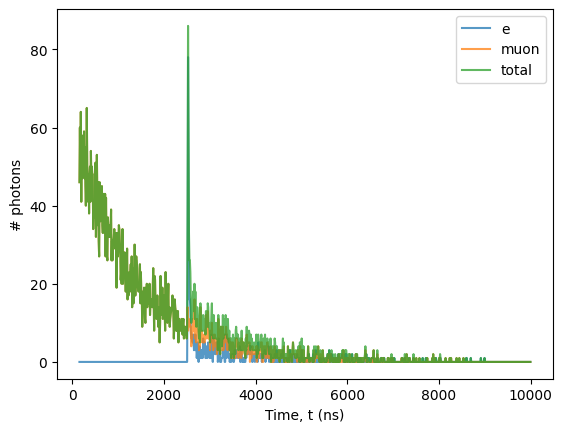

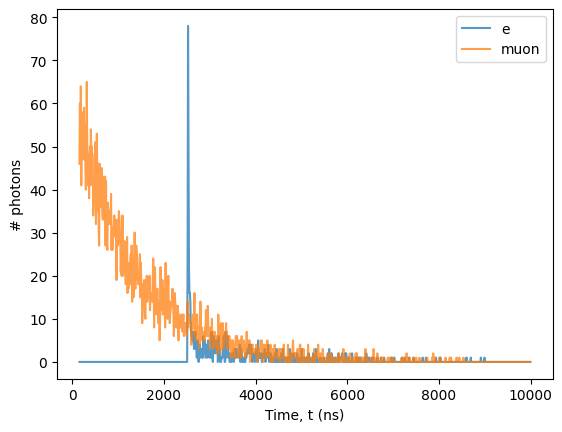

In [9]:
i = 4
print(idxs[i])
e_signal = np.array(e_signals.loc[idxs[i], t_idx]).reshape(-1)
mu_signal = np.array(mu_signals.loc[idxs[i], t_idx]).reshape(-1)
signal = np.array(signals.loc[idxs[i], t_idx]).reshape(-1)

v = [e_signal, mu_signal, signal]
plotSignals(t, v, ['e', 'muon', 'total'])

v = [e_signal, mu_signal]
plotSignals(t, v, ['e', 'muon'])

# Deep learning models

The first thing to know is how we should pass the data to a neural network and 
how to build its output layer. 

##  One time serie

For instance, let's imagine we have a neural network that only receives one 
time serie for the decomposition. 

In [12]:
from keras import Sequential
from keras.models import Model
from keras.layers import LSTM, Dense

a = np.array(e_signals.loc[idxs[i], t_idx]).reshape(-1,1)
b = np.array(mu_signals.loc[idxs[i], t_idx]).reshape(-1,1)
total = np.array(signals.loc[idxs[i], t_idx]).reshape(-1,1)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation = 'sigmoid', input_dim=1))
model.add(Dense(1, activation='linear'))

In [13]:
X = np.array(signals.loc[idxs[i], t_idx]).reshape(-1,1)
a = np.array(e_signals.loc[idxs[i], t_idx]).reshape(-1,1)
b = np.array(mu_signals.loc[idxs[i], t_idx]).reshape(-1,1)

In [14]:
np.shape(X)

(985, 1)

Epoch 1/100
28/28 [==============================] - 1s 6ms/step - loss: 13.9372 - val_loss: 0.0174
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 13.1349 - val_loss: 0.1555
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 12.8226 - val_loss: 0.2325
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 12.7206 - val_loss: 0.2565
Epoch 5/100
28/28 [==============================] - 0s 1ms/step - loss: 12.6679 - val_loss: 0.2184
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 12.6080 - val_loss: 0.1727
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 12.5879 - val_loss: 0.1385
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 12.5587 - val_loss: 0.1093
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 12.5505 - val_loss: 0.0948
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 12.5370 - val_loss: 0.0673

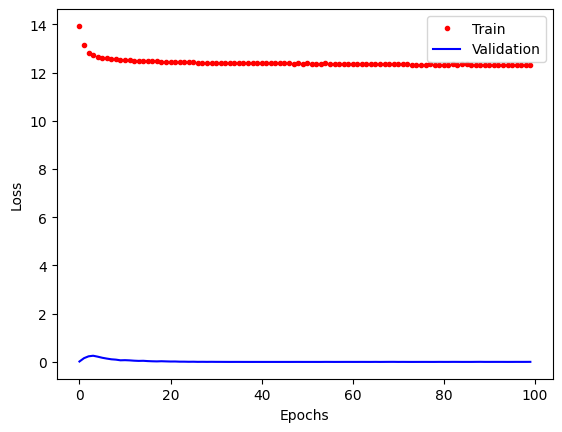

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X, a, batch_size=32, epochs=100, 
                    validation_split=0.1)

NN_trainPlot(history)

Obviously, the model is too simple to achieve a good result, we are just learning
what data and how to give it to the model.

31/31 [==============================] - 0s 587us/step


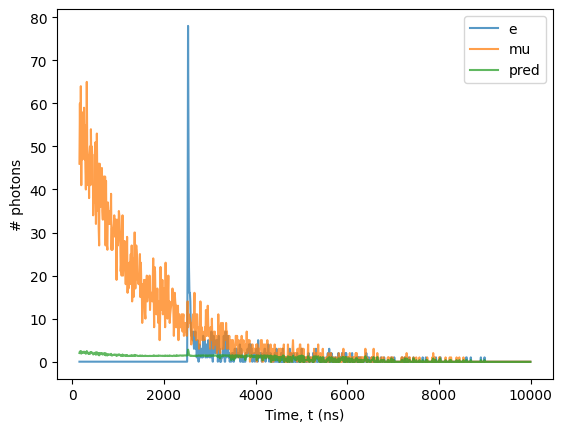

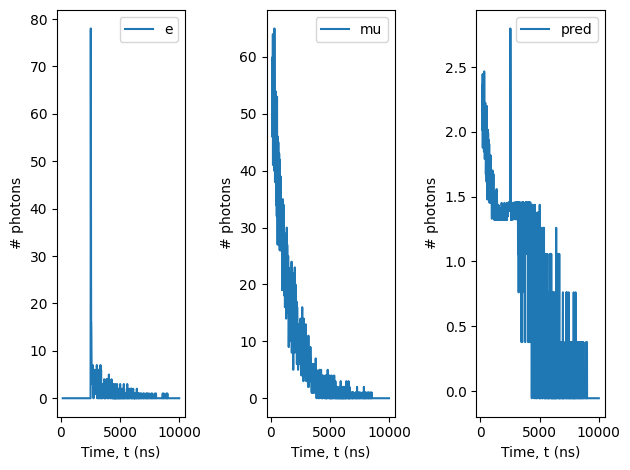

In [17]:
pred = model.predict(X)

v = [a, b, np.array(pred).reshape(-1,1)]
plotSignals(t, v, ['e', 'mu', 'pred'])
plotSignals(t, v, ['e', 'mu', 'pred'], sep=True)

As we can see from the earlier figures, the NN is capable of extracting the data.  
Now, let's create an equal model that also receives the signal of the muon as a 
feature:

In [18]:
X = np.array(signals.loc[idxs[i], t_idx]).reshape(-1,1)
X_m = np.array([X, b])
X_m.shape
# y = a

(2, 985, 1)

In [19]:
model = Sequential()
model.add(LSTM(units=50, activation = 'sigmoid', input_shape=(985,1)))
model.add(Dense(1, activation='linear'))

Epoch 1/50
1/1 [==============================] - 1s 622ms/step - loss: 8.1316e-08 - val_loss: 0.0022
Epoch 2/50
1/1 [==============================] - 0s 103ms/step - loss: 0.0022 - val_loss: 1.5470e-05
Epoch 3/50
1/1 [==============================] - 0s 101ms/step - loss: 1.5470e-05 - val_loss: 0.0015
Epoch 4/50
1/1 [==============================] - 0s 102ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/50
1/1 [==============================] - 0s 107ms/step - loss: 0.0013 - val_loss: 2.0408e-04
Epoch 6/50
1/1 [==============================] - 0s 104ms/step - loss: 2.0409e-04 - val_loss: 1.1898e-04
Epoch 7/50
1/1 [==============================] - 0s 102ms/step - loss: 1.1898e-04 - val_loss: 7.5396e-04
Epoch 8/50
1/1 [==============================] - 0s 105ms/step - loss: 7.5396e-04 - val_loss: 8.5358e-04
Epoch 9/50
1/1 [==============================] - 0s 101ms/step - loss: 8.5358e-04 - val_loss: 3.6104e-04
Epoch 10/50
1/1 [==============================] - 0s 99ms/step - loss

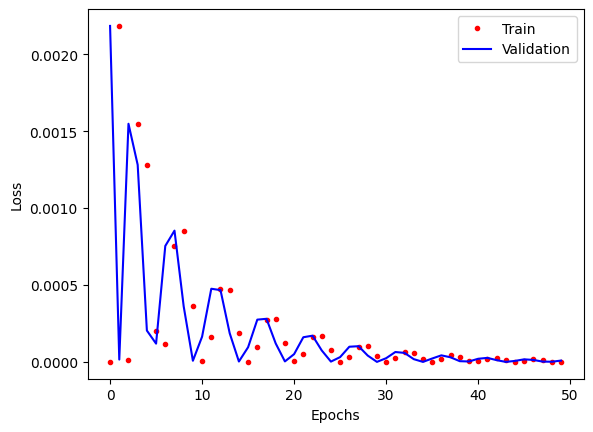

In [24]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_m, a, batch_size=30, epochs=50, 
                    validation_split=0.1)
NN_trainPlot(history)

In this case, this little neural network achieves to minimize the loss in 
validation and not overfitting. This implies that adding the signal of the muon 
as a features is a good option.

31/31 [==============================] - 0s 532us/step


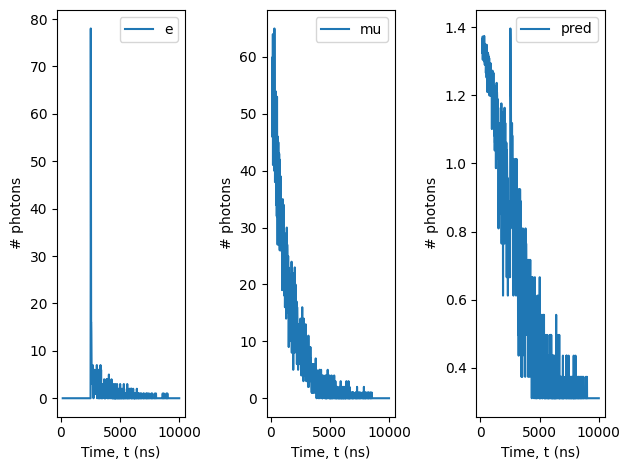

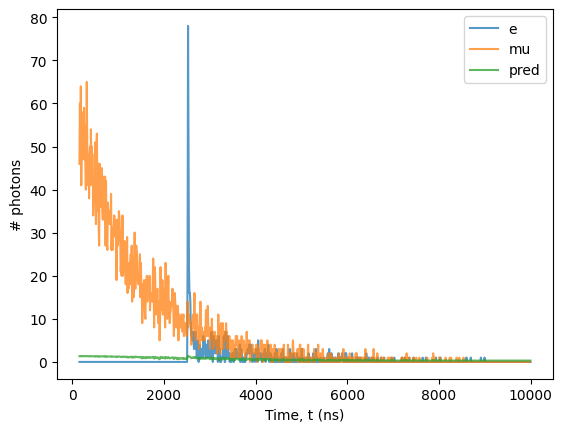

In [26]:
pred = model.predict(X)

v = [a, b, np.array(-pred).reshape(-1,1)]
plotSignals(t, v, ['e', 'mu', 'pred'], sep=True)
plotSignals(t, v, ['e', 'mu', 'pred'], sep=False)

When predicting, we have still the same problem it seems the predicted serie is 
too low although the loss 